In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.font_manager import FontProperties
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE

In [2]:
# === Загрузка данных ===
df = pd.read_excel('Заявки.xlsx')

In [3]:
# === Преобразование даты ===
df['Дата'] = pd.to_datetime(df['Дата'], format='%d.%m.%Y')
df['День недели'] = df['Дата'].dt.dayofweek
df['Месяц'] = df['Дата'].dt.month
df = df.sort_values('Дата')

# === Фильтрация данных ===
values_to_keep = [
    'Закупка у единственного поставщика (до 100 000 (500 000) рублей) (старое название - закупка без проведения закупочных процедур)',
    'Закупка у единственного поставщика',
    'Запрос предложений',
    'Запрос котировок'
]
df = df[df['Способ закупки'].isin(values_to_keep)]
df = df[df['Проект'].isin([
    'ЦСО ТС 2021(ГК №2123187347701432539210101)', 'Основной проектный ГОЗ(филиалы)', 
   'Основной', 'ГОМУ ГШ ВС РФ Военкоматы 2020-2022', 'СО 21-25 (2123187346132442539215312)', 
   'ЦСО ТС 2023 (ГК№2325187947401432539200843)', 'ЦСО ТС 2019 (ГК №1921187347503432539200843)',
   'ЭТО 2022', 'ЭТО 2023', 'ЭТО 2024', 'ЭТО 2025 (проект)'
])]
df = df[df['Подразделение'].isin([
    'Хабаровский филиал АО "Воентелеком"', 'Северо-Кавказский филиал АО "Воентелеком"', 'Приволжско-Уральский филиал АО "Воентелеком"',
    'Ивановский филиал АО "Воентелеком" - 733 ЦРЗСС', 'Санкт-Петербургский филиал АО "Воентелеком" - 521 ЦРЗСС', 
    'Воронежский филиал АО "Воентелеком" - 127 ВЗ','Калининградский филиал АО "Воентелеком" - 772 РЗСС', 
    'Центр обслуживания ИТ', 'Приморский филиал АО "Воентелеком" - 741 РЗСС', 'Рыбинский филиал АО "Воентелеком" - 190 ЦРЗСС',
    'Северо-Кавказский филиал', 'Новосибирский филиал АО "Воентелеком"', 'Самарский филиал АО "Воентелеком"', 
    'Департамент информационных технологий', 'Центр обслуживания техники связи', 'Центр ЭТО линий связи', 'Приволжско-Уральский филиал',
    'Мурманский филиал АО "Воентелеком" - 826 РЗСС'
])]

# === Подсчет количества закупок ===
data = df.value_counts(['Дата', 'Подразделение', 'Проект'], sort=False)
data = data.to_frame(name='Количество закупок').reset_index()

# Добавление дополнительных признаков ("День недели" и "Месяц") к агрегированным данным
data = data.merge(df[['Дата', 'День недели', 'Месяц']].drop_duplicates(), on='Дата', how='left')

# === Кодирование признаков ===
subdivision_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
project_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Применение OneHotEncoder
subdivision_encoded = subdivision_encoder.fit_transform(data[['Подразделение']])
project_encoded = project_encoder.fit_transform(data[['Проект']])

# Проверка размерностей
print(f"Размер subdivision_encoded: {subdivision_encoded.shape}")
print(f"Размер project_encoded: {project_encoded.shape}")
print(f"Размер data[['День недели', 'Месяц']]: {data[['День недели', 'Месяц']].shape}")

# Объединение всех признаков
X = np.concatenate([subdivision_encoded, project_encoded, data[['День недели', 'Месяц']].values], axis=1)
y = data['Количество закупок'].values

# === Применение SMOTE для балансировки данных ===
smote = SMOTE(random_state=42, k_neighbors=1)
X_balanced, y_balanced = smote.fit_resample(X, y)

# === Вывод результатов ===
print(f'Количество после балансировки: {X_balanced.shape[0]}')

Размер subdivision_encoded: (589, 15)
Размер project_encoded: (589, 6)
Размер data[['День недели', 'Месяц']]: (589, 2)
Количество после балансировки: 2196


In [4]:
# === Разделение на обучающие и тестовые выборки ===
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# === Обучение Random Forest ===
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# === Оценка модели ===
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}, R2: {r2:.4f}")

MSE: 0.0412, R2: 0.9695


In [5]:
# === Функция прогнозирования ===
# Список праздничных дней
holidays = [
    "2024-12-29", "2024-12-30", "2024-12-31",
    "2025-01-01", "2025-01-02", "2025-01-03", "2025-01-04", "2025-01-05", "2025-01-06",
    "2025-01-07", "2025-01-08", "2025-02-23", "2025-03-08", "2025-05-01", "2025-05-09", "2025-06-12", "2025-11-04"
]
holidays = pd.to_datetime(holidays)  # Преобразуем в формат datetime

def predict_future_with_onehot(data, model, steps_ahead, subdivision_encoder, project_encoder):
    unique_combinations = data[['Подразделение', 'Проект']].drop_duplicates()
    predictions = []

    # Используем текущую дату как начальную
    current_date = pd.to_datetime('today').normalize()  # Получаем сегодняшнюю дату без времени

    for _, row in unique_combinations.iterrows():
        subdivision = row['Подразделение']
        project = row['Проект']

        try:
            # Кодируем с помощью OneHotEncoder
            subdivision_encoded = subdivision_encoder.transform([[subdivision]])
            project_encoded = project_encoder.transform([[project]])
        except ValueError as e:
            print(f"Ошибка кодирования для Подразделение={subdivision}, Проект={project}: {e}")
            continue

        # Формируем начальные входные признаки
        input_features = np.hstack([
            subdivision_encoded,
            project_encoded,
            [[current_date.dayofweek + 1, current_date.month]]  # Преобразование dayofweek к {1: Понед. ..., 7: Воскр.}
        ])

        future_date = current_date
        step = 0
        while step < steps_ahead:
            future_date += pd.Timedelta(days=1)  # Переходим к следующему дню

            # Преобразуем день недели так, чтобы воскресенье было 7
            future_day_of_week = (future_date.dayofweek % 7) + 1  # Понедельник = 1, Воскресенье = 7

            # Проверка на выходные (суббота и воскресенье)
            if future_day_of_week in [6, 7] or future_date in holidays:
                continue  # Пропускаем выходной или праздничный день

            # Если день рабочий, делаем прогноз
            future_month = future_date.month
            pred = model.predict(input_features)[0]

            # Добавляем результат прогноза
            predictions.append({
                'Дата': future_date,
                'Подразделение': subdivision,
                'Проект': project,
                'День недели': future_day_of_week,
                'Месяц': future_month,
                'Количество закупок': pred
            })

            # Обновляем входные признаки
            input_features[:, -2:] = [[future_day_of_week, future_month]]

            step += 1

    if not predictions:
        print("Нет данных для прогнозирования. Проверьте соответствие категорий.")
        return pd.DataFrame()

    return pd.DataFrame(predictions)

In [6]:
# Подавляем предупреждения от scikit-learn
warnings.filterwarnings("ignore", category=UserWarning)

In [7]:
# === Прогнозирование ===
steps_ahead = int(input("Введите количество дней для прогноза: "))
future_df = predict_future_with_onehot(data, model, steps_ahead, subdivision_encoder, project_encoder)
if not future_df.empty:
    print(future_df)
else:
    print("Прогнозирование не выполнено.")

           Дата                                      Подразделение  \
0    2025-02-07  Санкт-Петербургский филиал АО "Воентелеком" - ...   
1    2025-02-10  Санкт-Петербургский филиал АО "Воентелеком" - ...   
2    2025-02-11  Санкт-Петербургский филиал АО "Воентелеком" - ...   
3    2025-02-12  Санкт-Петербургский филиал АО "Воентелеком" - ...   
4    2025-02-13  Санкт-Петербургский филиал АО "Воентелеком" - ...   
...         ...                                                ...   
1555 2025-03-14                Хабаровский филиал АО "Воентелеком"   
1556 2025-03-17                Хабаровский филиал АО "Воентелеком"   
1557 2025-03-18                Хабаровский филиал АО "Воентелеком"   
1558 2025-03-19                Хабаровский филиал АО "Воентелеком"   
1559 2025-03-20                Хабаровский филиал АО "Воентелеком"   

                                          Проект  День недели  Месяц  \
0                Основной проектный ГОЗ(филиалы)            5      2   
1              

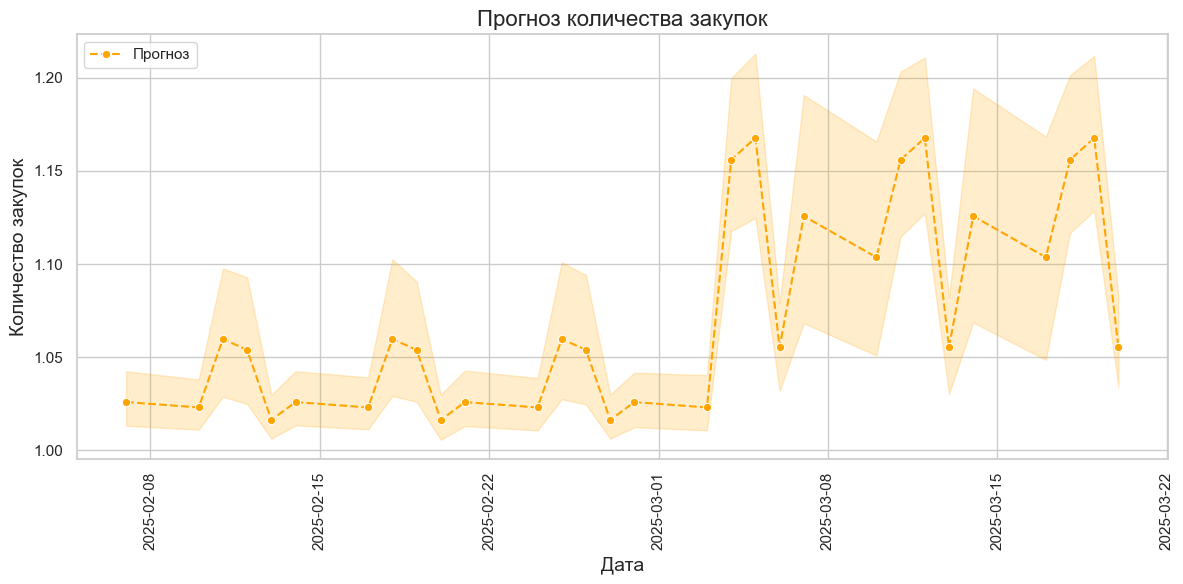

In [8]:
def plot_forecast_with_seaborn(future_df):
    """Строит график прогноза с использованием Seaborn."""
    # Устанавливаем стиль для графиков
    sns.set(style="whitegrid")

    # Строим график прогноза с помощью Seaborn
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        x='Дата',
        y='Количество закупок',
        data=future_df,
        label='Прогноз',
        color='orange',
        marker='o',
        linestyle='--',
        errorbar=('ci', 95)
    )

    # Добавляем заголовок и подписи осей
    plt.title('Прогноз количества закупок', fontsize=16)
    plt.xlabel('Дата', fontsize=14)
    plt.ylabel('Количество закупок', fontsize=14)

    # Форматирование дат на оси X
    plt.xticks(rotation=90)

    # Добавляем легенду
    plt.legend()

    # Показываем график
    plt.tight_layout()
    plt.show()

# Проверяем наличие данных для прогнозирования
if not future_df.empty:
    plot_forecast_with_seaborn(future_df)

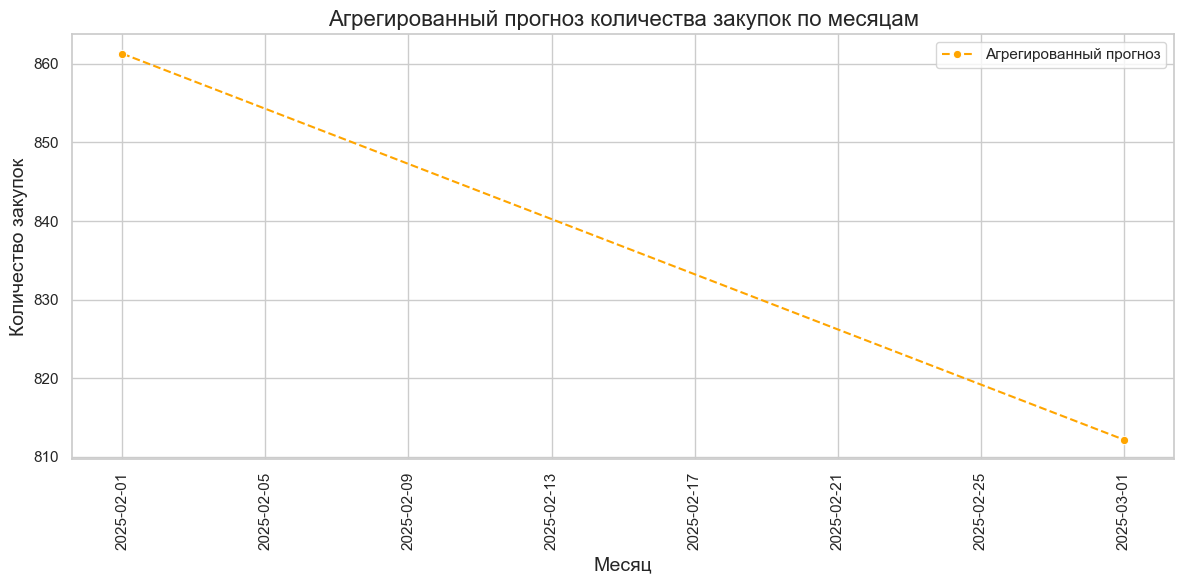

In [9]:
def plot_aggregated_forecast_with_seaborn(future_df):
    """Строит график агрегированного прогноза по месяцам с использованием Seaborn."""
    # Устанавливаем стиль для графиков
    sns.set(style="whitegrid")

    # Преобразуем дату в datetime
    future_df['Дата'] = pd.to_datetime(future_df['Дата'])

    # Агрегируем данные по месяцам и суммируем количество закупок
    future_df['Месяц'] = future_df['Дата'].dt.to_period('M')
    aggregated_df = future_df.groupby("Месяц", as_index=False)["Количество закупок"].sum()

    # Преобразуем обратно "Месяц" в формат datetime для корректной работы графика
    aggregated_df['Месяц'] = aggregated_df['Месяц'].dt.to_timestamp()

    # Строим график агрегированного прогноза
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        x="Месяц",
        y="Количество закупок",
        data=aggregated_df,
        label="Агрегированный прогноз",
        color="orange",
        marker="o",
        linestyle="--"
    )

    # Добавляем заголовок и подписи осей
    plt.title("Агрегированный прогноз количества закупок по месяцам", fontsize=16)
    plt.xlabel("Месяц", fontsize=14)
    plt.ylabel("Количество закупок", fontsize=14)

    # Форматирование дат на оси X
    plt.xticks(rotation=90)

    # Добавляем легенду
    plt.legend()

    # Показываем график
    plt.tight_layout()
    plt.show()

# Проверяем наличие данных для прогнозирования
if not future_df.empty:
    plot_aggregated_forecast_with_seaborn(future_df)

C:\Users\r.barannikov\AppData\Local\Temp\ipykernel_20792\3673338196.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


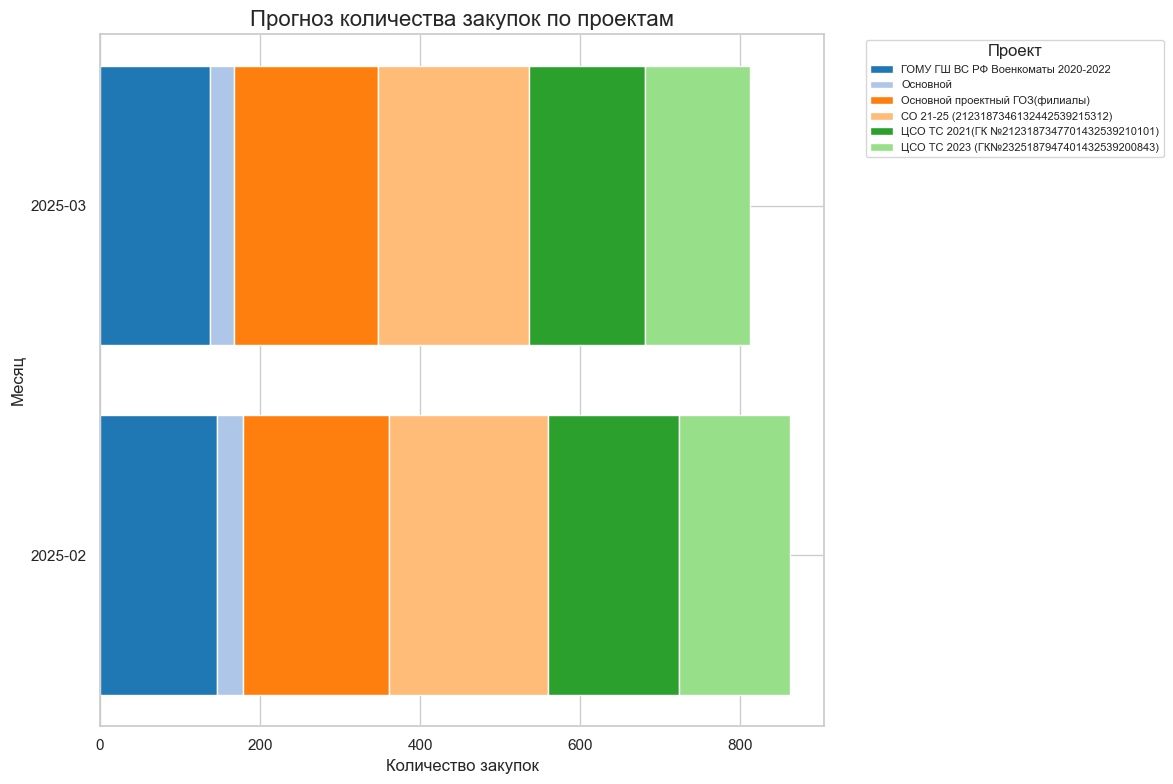

In [10]:
def plot_forecast_by_projects(future_df):
    # Преобразуем дату в datetime и добавляем столбец "Месяц"
    future_df['Дата'] = pd.to_datetime(future_df['Дата'])
    future_df['Месяц'] = future_df['Дата'].dt.to_period('M')

    # Агрегируем данные по месяцам и проектам, суммируя количество закупок
    monthly_data = future_df.groupby(['Месяц', 'Проект'])['Количество закупок'].sum().reset_index()

    # Создаем сводную таблицу для построения накопленного графика
    pivot_data = monthly_data.pivot(index='Месяц', columns='Проект', values='Количество закупок').fillna(0)

    # Получаем список проектов и месяцы
    projects = pivot_data.columns
    months = pivot_data.index.astype(str)

    # Используем colormap для генерации последовательности цветов
    cmap = get_cmap('tab20')
    colors = [cmap(i) for i in range(len(projects))]

    # Настройка графика
    plt.figure(figsize=(12, 8))
    left = None  # Начальная позиция для накопления

    # Для каждого проекта добавляем данные на график
    for i, projects in enumerate(projects):
        # Добавляем бары с накоплением
        plt.barh(months, pivot_data[projects], color=colors[i], label=projects, left=left)

        # Обновляем позицию для накопления
        if left is None:
            left = pivot_data[projects].values
        else:
            left += pivot_data[projects].values

    # Добавляем заголовок и подписи осей
    plt.title('Прогноз количества закупок по проектам', fontsize=16)
    plt.ylabel('Месяц', fontsize=12)
    plt.xlabel('Количество закупок', fontsize=12)

    # Размещаем легенду
    plt.legend(title='Проект', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8)

    # Показываем график
    plt.tight_layout()
    plt.show()

# Пример использования функции
if not future_df.empty:
    plot_forecast_by_projects(future_df)

C:\Users\r.barannikov\AppData\Local\Temp\ipykernel_20792\3751396820.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


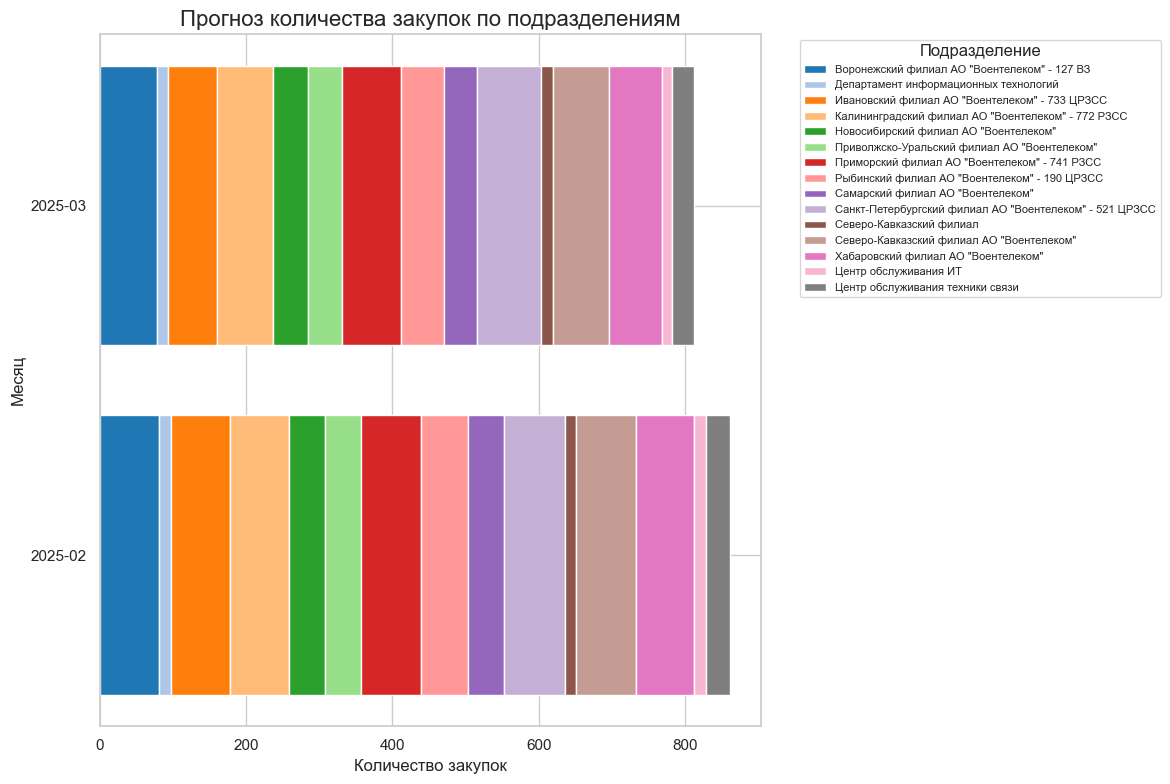

In [11]:
def plot_forecast_by_subdivision(future_df):
    # Преобразуем дату в datetime и добавляем столбец "Месяц"
    future_df['Дата'] = pd.to_datetime(future_df['Дата'])
    future_df['Месяц'] = future_df['Дата'].dt.to_period('M')

    # Агрегируем данные по месяцам и подразделениям, суммируя количество закупок
    monthly_data = future_df.groupby(['Месяц', 'Подразделение'])['Количество закупок'].sum().reset_index()

    # Создаем сводную таблицу для построения накопленного графика
    pivot_data = monthly_data.pivot(index='Месяц', columns='Подразделение', values='Количество закупок').fillna(0)

    # Получаем список подразделений и месяцы
    subdivisions = pivot_data.columns
    months = pivot_data.index.astype(str)

    # Используем colormap для генерации последовательности цветов
    cmap = get_cmap('tab20')
    colors = [cmap(i) for i in range(len(subdivisions))]

    # Настройка графика
    plt.figure(figsize=(12, 8))
    left = None  # Начальная позиция для накопления

    # Для каждого подразделения добавляем данные на график
    for i, subdivision in enumerate(subdivisions):
        # Добавляем бары с накоплением
        plt.barh(months, pivot_data[subdivision], color=colors[i], label=subdivision, left=left)

        # Обновляем позицию для накопления
        if left is None:
            left = pivot_data[subdivision].values
        else:
            left += pivot_data[subdivision].values

    # Добавляем заголовок и подписи осей
    plt.title('Прогноз количества закупок по подразделениям', fontsize=16)
    plt.ylabel('Месяц', fontsize=12)
    plt.xlabel('Количество закупок', fontsize=12)

    # Размещаем легенду
    plt.legend(title='Подразделение', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8)

    # Показываем график
    plt.tight_layout()
    plt.show()

# Пример использования функции
if not future_df.empty:
    plot_forecast_by_subdivision(future_df)

In [63]:
# Сохраняем датафрейм в файл Excel
future_df.to_excel('forecast.xlsx', index=False)